# SYSTEMIQ Assessment
The following notebook contains my analysis for the assessment for the 'Python Modeller - Energy Platform' at SYSTEMIQ. Everything contained within this notebook is my own work.

Victor Onink 26/04/2022

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from datetime import timedelta, datetime
import statsmodels.api as sm

### Data cleaning & merging
1. Please load the users and activity tables into Python

    a. How many variables are in the datasets
    
    b. How many observations are in the datasets

In [2]:
user_data = pd.read_csv('users.csv')
activity_data = pd.read_csv('activities.csv')

def data_parameters(data_set, name) -> print:
    """
    Print the number of observations and variables contained within the data_set. The data_set data is 
    structured according to [num_observations, num_variables]
    """
    print('The {} dataset has {} observations and {} variables.'.format(name, *data_set.shape))
    
data_parameters(user_data, 'user')
data_parameters(activity_data, 'activity')

The user dataset has 5807 observations and 5 variables.
The activity dataset has 22642 observations and 3 variables.


2. How many:
    
    a. Male users are in the dataset?
    
    b. Female users are in the dataset?
    
    c. For haw many users is no gender information available?

In [3]:
male_users = sum(user_data.Gender == 'M')
female_users = sum(user_data.Gender == 'F')
undefined_users = sum(user_data.Gender == ' ')

print('The dataset has {} male users.'.format(male_users))
print('The dataset has {} female users.'.format(female_users))
print('The dataset has {} users without available gender information.'.format(undefined_users))

The dataset has 2909 male users.
The dataset has 1417 female users.
The dataset has 1481 users without available gender information.


3. Merge the two datasets and calculate the days since registration for each activity. What is the total mean and median revenue generated per user (ie across all activities)? How do you interpret the result?

In [4]:
# Merging the data, where the join is done on the 'UserId' variable
merged_data = user_data.merge(activity_data, left_on='UserId', right_on='UserId')

# Calculating the total revenue for each user
total_revenue = merged_data.groupby('UserId').sum('Revenue')

# Calculate the mean and median revenue per user
mean_revenue = total_revenue.mean()
median_revenue = total_revenue.median()

print('The mean revenue is {:.2f}, the median revenue is {:.2f}'.format(mean_revenue.Revenue, median_revenue.Revenue))

The mean revenue is 512.69, the median revenue is 80.00


As can be seen above, the mean revenue is significantly higher than the median. This suggests that there are a number of users in the dataset that spend significantly more money over the various activities in the dataset than others.

4. Please visualize the distribution of the revenues by user.

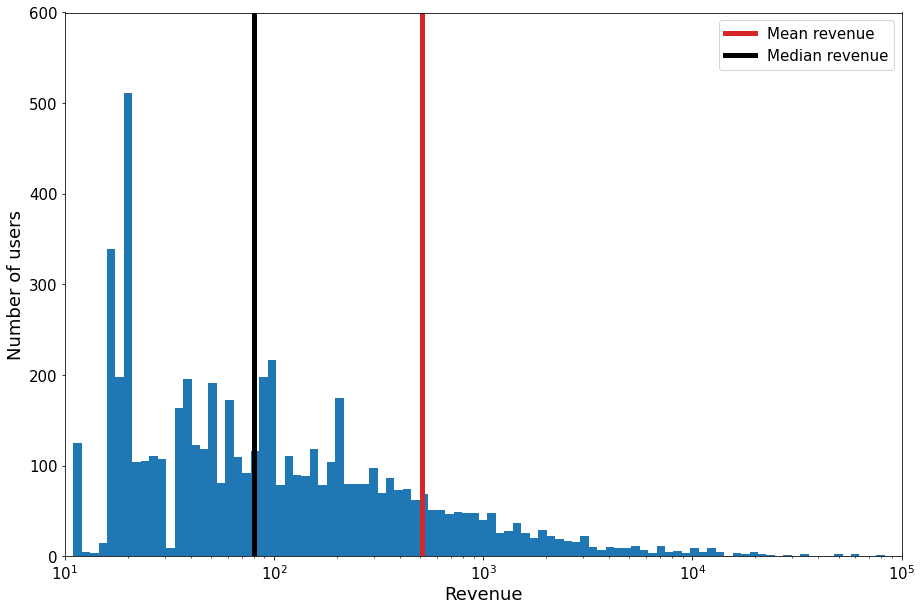

In [5]:
# We can just make a simple 1D histogram of the data, with revenueon x axis and number of users on the y axis
def plot_histogram(revenue_data, mean_rev, median_rev) -> plt.figure:
    """
    This function makes a standard histogram of the revenue_data, as well as indicating the mean and median 
    revenues (mean_rev, median_rev).
    """
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111)
    counts, bins, _ = ax.hist(revenue_data, bins=np.logspace(1, 5, num=100))

    # Setting the axis labels
    plt.xlabel('Revenue', fontsize=18)
    plt.ylabel('Number of users', fontsize=18)
    _ = plt.xticks(fontsize=15)
    _ = plt.yticks(fontsize=15)

    # Setting the axis limits and making the x axis a log scale
    plt.xlim(10, 1e5)
    plt.ylim(0, 600)
    plt.xscale('log')

    # Plotting the mean and median values
    plt.axvline(x=mean_rev, color='tab:red', linewidth=5, label='Mean revenue')
    plt.axvline(x=median_rev, color='black', linewidth=5, label='Median revenue')

    _ = ax.legend(fontsize=15)
    
plot_histogram(total_revenue, mean_revenue.Revenue, median_revenue.Revenue)

The figure above shows that the revenue per user distribution is highly skewed, which was already expected based on the large difference between the mean and median values. Half of the users spend less than 80 euro on activities, but there are a small number of users that spend 10,000 - 100,000 euro. As such, the mean revenue per user is 512.69 euro, even though the majority of the users spend signigicantly less than that.

5. What is the average week 1 revenue (ie the revenue generated by the user in the first week)?

The week 1 mean revenue is 200.25, the median revenue is 50.00


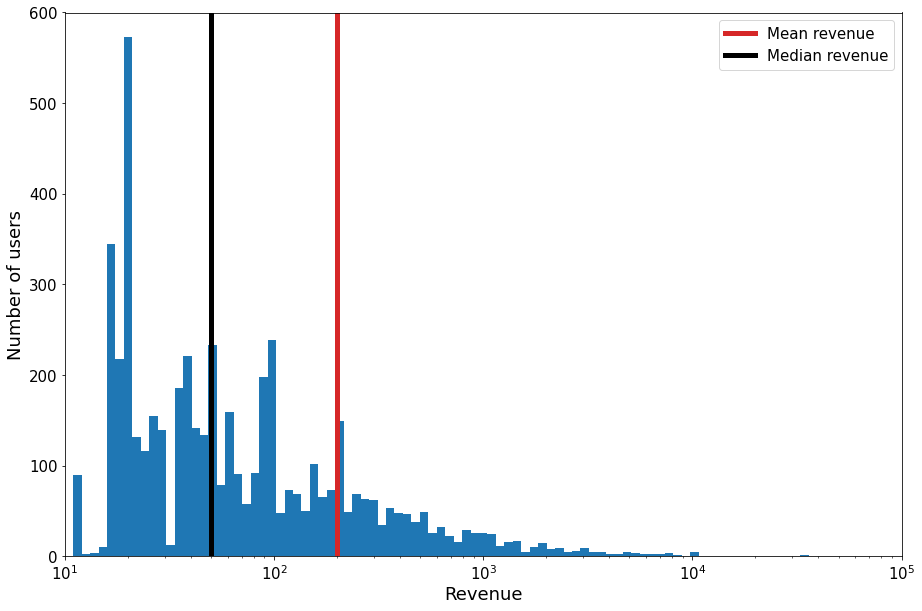

In [6]:
def get_period_events(all_data, time_period=7) -> pd.DataFrame:
    """
    Returns a boolean DataFrame that indicates which events occur within time_period days of registration
    """
    # Assure that the time columns are all in datetime format
    all_data.RegDate = pd.to_datetime(merged_data.RegDate)
    all_data.Date = pd.to_datetime(merged_data.Date)
    
    # Calculate the difference in days between the Date and the RegDate
    days_difference = all_data.Date - all_data.RegDate 
    
    # Calculate the revenue per user within time_period days of registration
    return days_difference.dt.days <= time_period
    

week1_events_bool = get_period_events(merged_data)
week1_events = merged_data.loc[week1_events_bool]
week1_revenue = week1_events.groupby('UserId').sum('Revenue')

# Calculate the mean and median revenue per user
mean_week1_revenue = week1_revenue.mean()
median_week1_revenue = week1_revenue.median()

print('The week 1 mean revenue is {:.2f}, the median revenue is {:.2f}'.format(mean_week1_revenue.Revenue, 
                                                                               median_week1_revenue.Revenue))
plot_histogram(week1_revenue, mean_week1_revenue.Revenue, median_week1_revenue.Revenue)

As we can see with the histogram above, if we just consider the mean/median revenue per user in their first week since registration, the averages are lower. There are still a number of high values (>10,000 euro), but they are less common. As such, the averages over the entire dataset are influenced by that a number of users have been using the service more longer periods of time, which is why the average revenue is higher. 

### Analytics
6. In this dataset men generated a higher week 1 revenue than women, on average.  Is this difference in revenue between men and women statistically significant? What is an appropriate statistical test to determine this and what is it’s p-value?

In [7]:
# First, we replace all missing gender values with 'M', as required by the assignment 
merged_data.Gender = np.where((merged_data.Gender == ' '), 'M', merged_data.Gender)

# Next, split the data according to male/female
male_data = merged_data[merged_data.Gender == 'M']
female_data = merged_data[merged_data.Gender == 'F']

# Now, we sort out all the events that are in the first week of registration
male_days_difference = male_data.Date - male_data.RegDate
female_days_difference = female_data.Date - female_data.RegDate
male_week1_events = male_data[male_days_difference.dt.days <= 7]
female_week1_events = female_data[female_days_difference.dt.days <= 7]

# Calculate the revenue per person 
male_revenue = male_week1_events.groupby('UserId').sum('Revenue')
female_revenue = female_week1_events.groupby('UserId').sum('Revenue')

# Now, we can conduct the independent sample t test to compare the dataset
t_value, p_value = ttest_ind(male_revenue.Revenue, female_revenue.Revenue)

# Printing the results
print('The mean male revenue is {:.2f}±{:.2f} euro'.format(male_revenue.Revenue.mean(), male_revenue.Revenue.std()))
print('The mean female revenue is {:.2f}±{:.2f} euro'.format(female_revenue.Revenue.mean(), female_revenue.Revenue.std()))
print('the independent t-test value is {:.3f}, with significance {:.3f}'.format(t_value, p_value))


The mean male revenue is 207.99±788.82 euro
The mean female revenue is 174.69±576.33 euro
the independent t-test value is 1.349, with significance 0.177


The mean revenue for men and women is quite similar, especially given the large standard deviation on both of these values (as a result of the extremely high spenders shown in the histograms earlier). Given that male/female makes for two completely independent datasets, the independent sample t test is a suitable metric to see whether this difference is significant. With a significance value $p=0.177$, we can conclude that there is not a significant difference in the amount of revenue generated by male and female users.

7. In which country is this difference greatest?
8. Please visualise the relationship between country, gender and week 1 revenue with an appropriate chart.

In [8]:
# We are going to take the male/female revenue and split them up into different countries
male_country = male_week1_events.groupby(['Country', 'UserId']).sum('Revenue')
female_country = female_week1_events.groupby(['Country', 'UserId']).sum('Revenue')

# Next we calculate the average for each country
male_country_mean = male_country.groupby('Country').mean('Revenue')
female_country_mean = female_country.groupby('Country').mean('Revenue')

# We also calculate the standard deviation
male_country_std = male_country.groupby('Country').std()
female_country_std = female_country.groupby('Country').std()


# Calculate the difference
difference_revenue = np.abs(male_country_mean - female_country_mean)

print('The absolute difference in revenue for men and women is each country is:')
print(difference_revenue)
max_region = difference_revenue.idxmax().values[0]
str_format = max_region, male_country_mean.Revenue.loc[max_region], female_country_mean.Revenue.loc[max_region]
print('So, we can conclude the largest difference is in {}, where men generate {:.2f} and women {:.2f}'.format(*str_format))

The absolute difference in revenue for men and women is each country is:
           Revenue
Country           
DE       30.651792
FR       28.066291
GB       17.140430
Other    70.622211
US       63.705906
So, we can conclude the largest difference is in Other, where men generate 159.05 and women 88.42


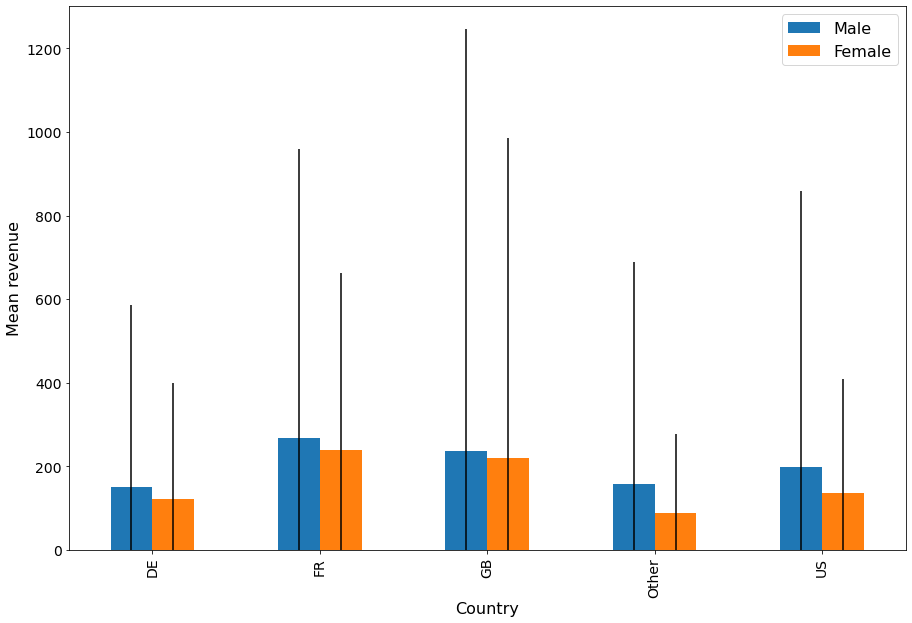

In [9]:
# To compare the values in each region, we will create a bar graph. For this, we first combine the two dataframes
join_pd = pd.DataFrame({'Country': male_country_mean.index,
                        'Male': male_country_mean.Revenue,
                        'Female': female_country_mean.Revenue,
                        'Male_std': male_country_std.Revenue,
                        'Female_std': female_country_std.Revenue})

# Create the figure
plt.rc('axes', titlesize=16)     # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)
join_pd.plot(x="Country", y=["Male", "Female"], kind="bar", ax=ax, yerr=join_pd[['Male_std', 'Female_std']].T.values)
ax.set_ylim([0, 1300])
_ = ax.set_ylabel('Mean revenue')


So, from the analysis we can see that men generally generate more mean revenue than women, and this is a trend that is visible over all regions included within the data set. The difference is largest in the 'Other' region, where the large difference here might be due to having a range of different regions being put together into one category. We can also see that all regions show high variability in the data, which is illustrated by the large uncertainty bars in the data.

9.	Build a linear regression model to predict the week 1 revenue of a user based on the following variables: Gender, Age, Country and day 1 revenue (ie the revenue generated by the user on their registration date). Which of these variables have a statistically significant predictive power according to this model?

In [10]:
# First, we need to calculate the day 1 and week 1revenue, which can just follow the procedure we used for the 
# 7 day revenue
day1_events_bool = get_period_events(merged_data, time_period=0)
week1_events_bool = get_period_events(merged_data, time_period=7)

# Now, we set the revenue for all events outside of 1 day or 1 week to 0
day1_revenue, week1_revenue = merged_data.Revenue.copy(deep=True), merged_data.Revenue.copy(deep=True)
day1_revenue[day1_events_bool == False] = 0
week1_revenue[week1_events_bool == False] = 0

# And now the mean revenue per person for week1 and day1
merged_data['week1_revenue'] = week1_revenue
merged_data['day1_revenue'] = day1_revenue
user_mean_revenue = merged_data.groupby('UserId').sum(['week1_revenue', 'day1_revenue'])

# Now we merge these revenues with the users
complete_data = user_data.merge(user_mean_revenue, on='UserId')
    
# Finally, we calculate the age of the person relative to today
today = datetime.now()
complete_data.DOB = pd.to_datetime(complete_data.DOB)
complete_data['age'] = (today - complete_data.DOB).dt.days // 365.25

# And then we again make sure all unmarked genders are 'M', and then create dummy variables since the linear 
# regression model doesn't like string
complete_data.Gender = np.where((complete_data.Gender == ' '), 'M', complete_data.Gender)
complete_data = pd.get_dummies(complete_data, columns=['Gender'], drop_first=True)

# Similarly, we generate dummy variables for the countries
complete_data = pd.get_dummies(complete_data, columns=['Country'], drop_first=True)
print(complete_data)

       UserId        DOB     RegDate  Revenue  week1_revenue  day1_revenue  \
0     1326865 1988-05-04  2016-03-24   351.42           0.00          0.00   
1     1333278 1971-07-21  2016-02-09    45.00           0.00          0.00   
2     1336967 1983-07-31  2016-01-29    20.00           0.00          0.00   
3     1339784 1976-09-21  2016-01-21    59.28           0.00          0.00   
4     1339829 1981-05-03  2016-04-12    17.05           0.00          0.00   
...       ...        ...         ...      ...            ...           ...   
5792  3347222 1967-05-25  2017-03-22   230.27          56.80         37.52   
5793  3347251 1981-06-11  2017-04-03    30.00          30.00         30.00   
5794  3347333 1987-11-22  2017-01-27    30.00          30.00         30.00   
5795  3347367 1995-08-09  2017-04-04    17.05          17.05         17.05   
5796  3347450 1994-07-30  2017-04-21    42.63          42.63         42.63   

       age  Gender_M  Country_FR  Country_GB  Country_Other  Co

In [11]:
# Now that we have all our variables of interest, we can create our linear regression model, with X being our
# training data and y the target data
X = complete_data[['Gender_M', 'age', 'day1_revenue', 'Country_FR', 'Country_GB', 'Country_Other', 'Country_US']]
y = complete_data['week1_revenue']

linear_model = sm.OLS(y, X).fit()
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          week1_revenue   R-squared (uncentered):                   0.485
Model:                            OLS   Adj. R-squared (uncentered):              0.484
Method:                 Least Squares   F-statistic:                              777.8
Date:                Tue, 26 Apr 2022   Prob (F-statistic):                        0.00
Time:                        17:11:24   Log-Likelihood:                         -44475.
No. Observations:                5797   AIC:                                  8.896e+04
Df Residuals:                    5790   BIC:                                  8.901e+04
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Gender_M          0.5074     14.131      0.036      0.971     -27.194      28.209
age               0.6533      0.370      1.766      0.078      -0.072       1.379
day1_revenue      1.4593      0.021     68.688      0.000       1.418       1.501
Country_FR       29.8458     28.415      1.050      0.294     -25.858      85.550
Country_GB       22.2315     18.005      1.235      0.217     -13.065      57.528
Country_Other    -1.2415     22.490     -0.055      0.956     -45.330      42.847
Country_US       -2.6947     21.406     -0.126      0.900     -44.659      39.270
==============================================================================
Omnibus:                    14676.084   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        394547536.172
Skew:                          27.660   Prob(JB):                         0.00
Kurtosis:                    1279.869   Cond. No.                     1.71e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.71e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

So, if we look at the results above, we can see that only the `day1_revenue` has significant predictive power ($p<0.05$), although `age` is very close to significant. In contrast, the user gender has very little predictive power, which is in line with the earlier conclusion that the mean revenue generated by men and women is not significantly different. The nationality of the user is also not a signficant predictor, and this is also to be expected, given that the bar plot shows that all the male/female mean revenues fall within each other's standard deviation.

In short, a model just using the user `age` and `day1_revenue` is likely the best predictive model that you could get from this dataset.

10.	What revenues do you expect women from France, Germany and the UK to generate, assuming they are all aged 40 and all generated £20 on their registration day?

In [12]:
# To make these predictions, we first create a dataframe with the necessary data
users = pd.DataFrame({'Gender_M': [0, 0, 0], 'age': [40, 40, 40], 'day1_revenue': [20, 20, 20],
                      'Country_FR': [1, 0, 0], 'Country_GB': [0, 1, 0], 'Country_Other': [0, 0, 0],
                      'Country_US': [0, 0, 0]})

print(linear_model.predict(users))

0    85.164513
1    77.550216
2    55.318754
dtype: float64


So, based on this linear regression model, we would expect a 40 year old women in France, Germany and the UK respectively to generate 85.16, 55.32 and 77.55 pounds of revenue.